# Mappa colori della multi-lorentziana

---

## Preparazione dei dati

Leggo direttamente dai file contenenti solamente la multi-lorentziana.

In [1]:
from odmr_subroutines.analysis_subroutines import *
    
def build_name (dist):
    return f"data/cristallo2_n_lorentzians/odmr_dist_{dist}_lorentz.csv"

distanze = [17, 19, 20, 22, 24, 30, 33, 39, 40, 1000]

Raccolgo tre colonne in ciascun file: freq, od, lock. Occhio: file diversi hanno colonne di lunghezze diverse. Occorre uniformare le lunghezze prima di fare la heatmap!

In [2]:
freq_data = []
spectra_data = []
lock_in_data = []

max_lenght = -10

for i, dist in enumerate( reversed(distanze) ):
    nome = build_name(dist)
    data = np.loadtxt(nome, skiprows=2, delimiter='|')
    freq_data.append(data[:,0].tolist())  # Converto in lista
    spectra_data.append(data[:,1].tolist())  # Converto in lista
    
    # Se il file ha una terza colonna, la uso per lock_in, altrimenti creo zeri
    if data.shape[1] > 2:
        lock_in_data.append(data[:,2].tolist())
    else:
        lock_in_data.append([0.0] * len(data[:,0]))
    
    if data[:,0].size > max_lenght:
        max_lenght = data[:,0].size
        idx_max_lenght = i

Prendo il file con le colonne più lunghe. Guardo gli estremi delle frequenze. Faccio in modo che tutti gli altri file abbiano lo stesso range di frequenze e lo stesso numero di punti, semplicemente aggiungendone tanti quanti ne servono. Le frequenze tanto vanno di 0.5 in 0.5; in od e lock metto un bello 0.

In [3]:
estremo_sx = freq_data[idx_max_lenght][0]
estremo_dx = freq_data[idx_max_lenght][-1]

for i in range(len(freq_data)):
    # controllo se la colonna corrente è più corta della più lunga
    if max_lenght > len(freq_data[i]):
        # Salvo i valori originali prima di modificare
        freq_orig = freq_data[i].copy()
        spectra_orig = spectra_data[i].copy()
        lock_orig = lock_in_data[i].copy()
        
        # controllo se manca qualcosa all'inizio:
        if freq_orig[0] > estremo_sx:
            # Aggiungo punti all'inizio
            n_points_start = int(round((freq_orig[0] - estremo_sx)/0.25))
            freq_start = [estremo_sx + j*0.25 for j in range(n_points_start)]
            freq_data[i] = freq_start + freq_orig
            spectra_data[i] = [0.0] * n_points_start + spectra_orig
            lock_in_data[i] = [0.0] * n_points_start + lock_orig
        
        # poi controllo se manca qualcosa alla fine:
        if freq_data[i][-1] < estremo_dx:
            # Aggiungo punti alla fine
            n_points_end = int(round((estremo_dx - freq_data[i][-1])/0.25))
            freq_end = [freq_data[i][-1] + j*0.25 for j in range(1, n_points_end + 1)]
            freq_data[i] += freq_end
            spectra_data[i] += [0.0] * n_points_end
            lock_in_data[i] += [0.0] * n_points_end

        # infine, controllo che siano lunghi uguali!
        '''if max_lenght > len(freq_data[i]):
            print(f"ERRORE: la colonna {i} ({len(freq_data[i])}) è ancora più corta della più lunga ({max_lenght})!")'''

In [4]:
def interpola_colonna_mancante(freq_orig, data_orig, freq_target_step=0.25):
    """Interpola una colonna con step più grandi su una griglia più fine"""
    
    # Crea la nuova griglia con step desiderato
    freq_min, freq_max = freq_orig[0], freq_orig[-1]
    n_points = int((freq_max - freq_min) / freq_target_step) + 1
    freq_new = np.linspace(freq_min, freq_max, n_points)
    
    # Interpolazione lineare
    data_new = np.interp(freq_new, freq_orig, data_orig)
    
    return freq_new.tolist(), data_new.tolist()

'''print("Lunghezze prima della correzione finale:")
for i in range(len(freq_data)):
    print(f"File {i}: {len(freq_data[i])} punti")'''

# FORZA tutte le colonne ad avere la stessa lunghezza
target_length = max(len(col) for col in freq_data)
#print(f"Lunghezza target: {target_length}")

for i in range(len(freq_data)):
    if len(freq_data[i]) != target_length:
        #print(f"Correggendo file {i}: da {len(freq_data[i])} a {target_length}")
        
        # Salva originali
        freq_orig = freq_data[i].copy()
        spectra_orig = spectra_data[i].copy()
        lock_orig = lock_in_data[i].copy()
        
        # Trova il file con lunghezza target come riferimento
        idx_target = next(j for j in range(len(freq_data)) if len(freq_data[j]) == target_length)
        freq_target = freq_data[idx_target]
        
        # Interpola su questa griglia
        spectra_new = np.interp(freq_target, freq_orig, spectra_orig)
        lock_new = np.interp(freq_target, freq_orig, lock_orig)
        
        # Sostituisci
        freq_data[i] = freq_target.copy()  # Usa le stesse frequenze
        spectra_data[i] = spectra_new.tolist()
        lock_in_data[i] = lock_new.tolist()

# Verifica finale
'''print("Lunghezze dopo correzione:")
for i in range(len(freq_data)):
    print(f"File {i}: freq={len(freq_data[i])}, spettro={len(spectra_data[i])}, lock={len(lock_in_data[i])}")'''


'print("Lunghezze dopo correzione:")\nfor i in range(len(freq_data)):\n    print(f"File {i}: freq={len(freq_data[i])}, spettro={len(spectra_data[i])}, lock={len(lock_in_data[i])}")'

Riarrangio i dati

In [5]:
'''for i, dist in enumerate( reversed(distanze) ):
    spectra_data[i] = [spectra_data[i][j] if spectra_data[i][j] <= 0 else 0 for j in range(len(spectra_data[i]))]'''

'for i, dist in enumerate( reversed(distanze) ):\n    spectra_data[i] = [spectra_data[i][j] if spectra_data[i][j] <= 0 else 0 for j in range(len(spectra_data[i]))]'

In [6]:
dists = np.array(distanze[:-1]+[60]) # distanze, da cui poi ricaverò il campo B, ma lo faccio io dopo
freq_data_col = np.column_stack(freq_data)
Z_spectro = np.column_stack(spectra_data)
Z_lockin  = np.column_stack(lock_in_data)

#### In termini di campo magnetico e con i fit

In [7]:
popt_array = [np.array([17733.81212066,  2860.      ]),
 np.array([5875.11124235, 2860.        ]),
 np.array([2295.31562963, 2860.        ]),
 np.array([4000., 2865.                ]),
 np.array([8533.26424074, 2856.77626602]),
 np.array([16294.34042172,  2865.      ])]
    

In [8]:
def funzione_fit_plus(B, gamma_fit, D):
    return D + np.sqrt(100 + (gamma_fit*B)**2)
def funzione_fit_minus(B, gamma_fit, D):
    return D - np.sqrt(100 + (gamma_fit*B)**2)

In [9]:
previsioni_B = np.array(list(reversed([0.01685433, 0.01270503, 0.01110222, 0.00857636, 0.00671791, 0.00345788, 0.00255966, 0.00147035, 0.00134735, 0])))*1000 # in mT

### Heatmap

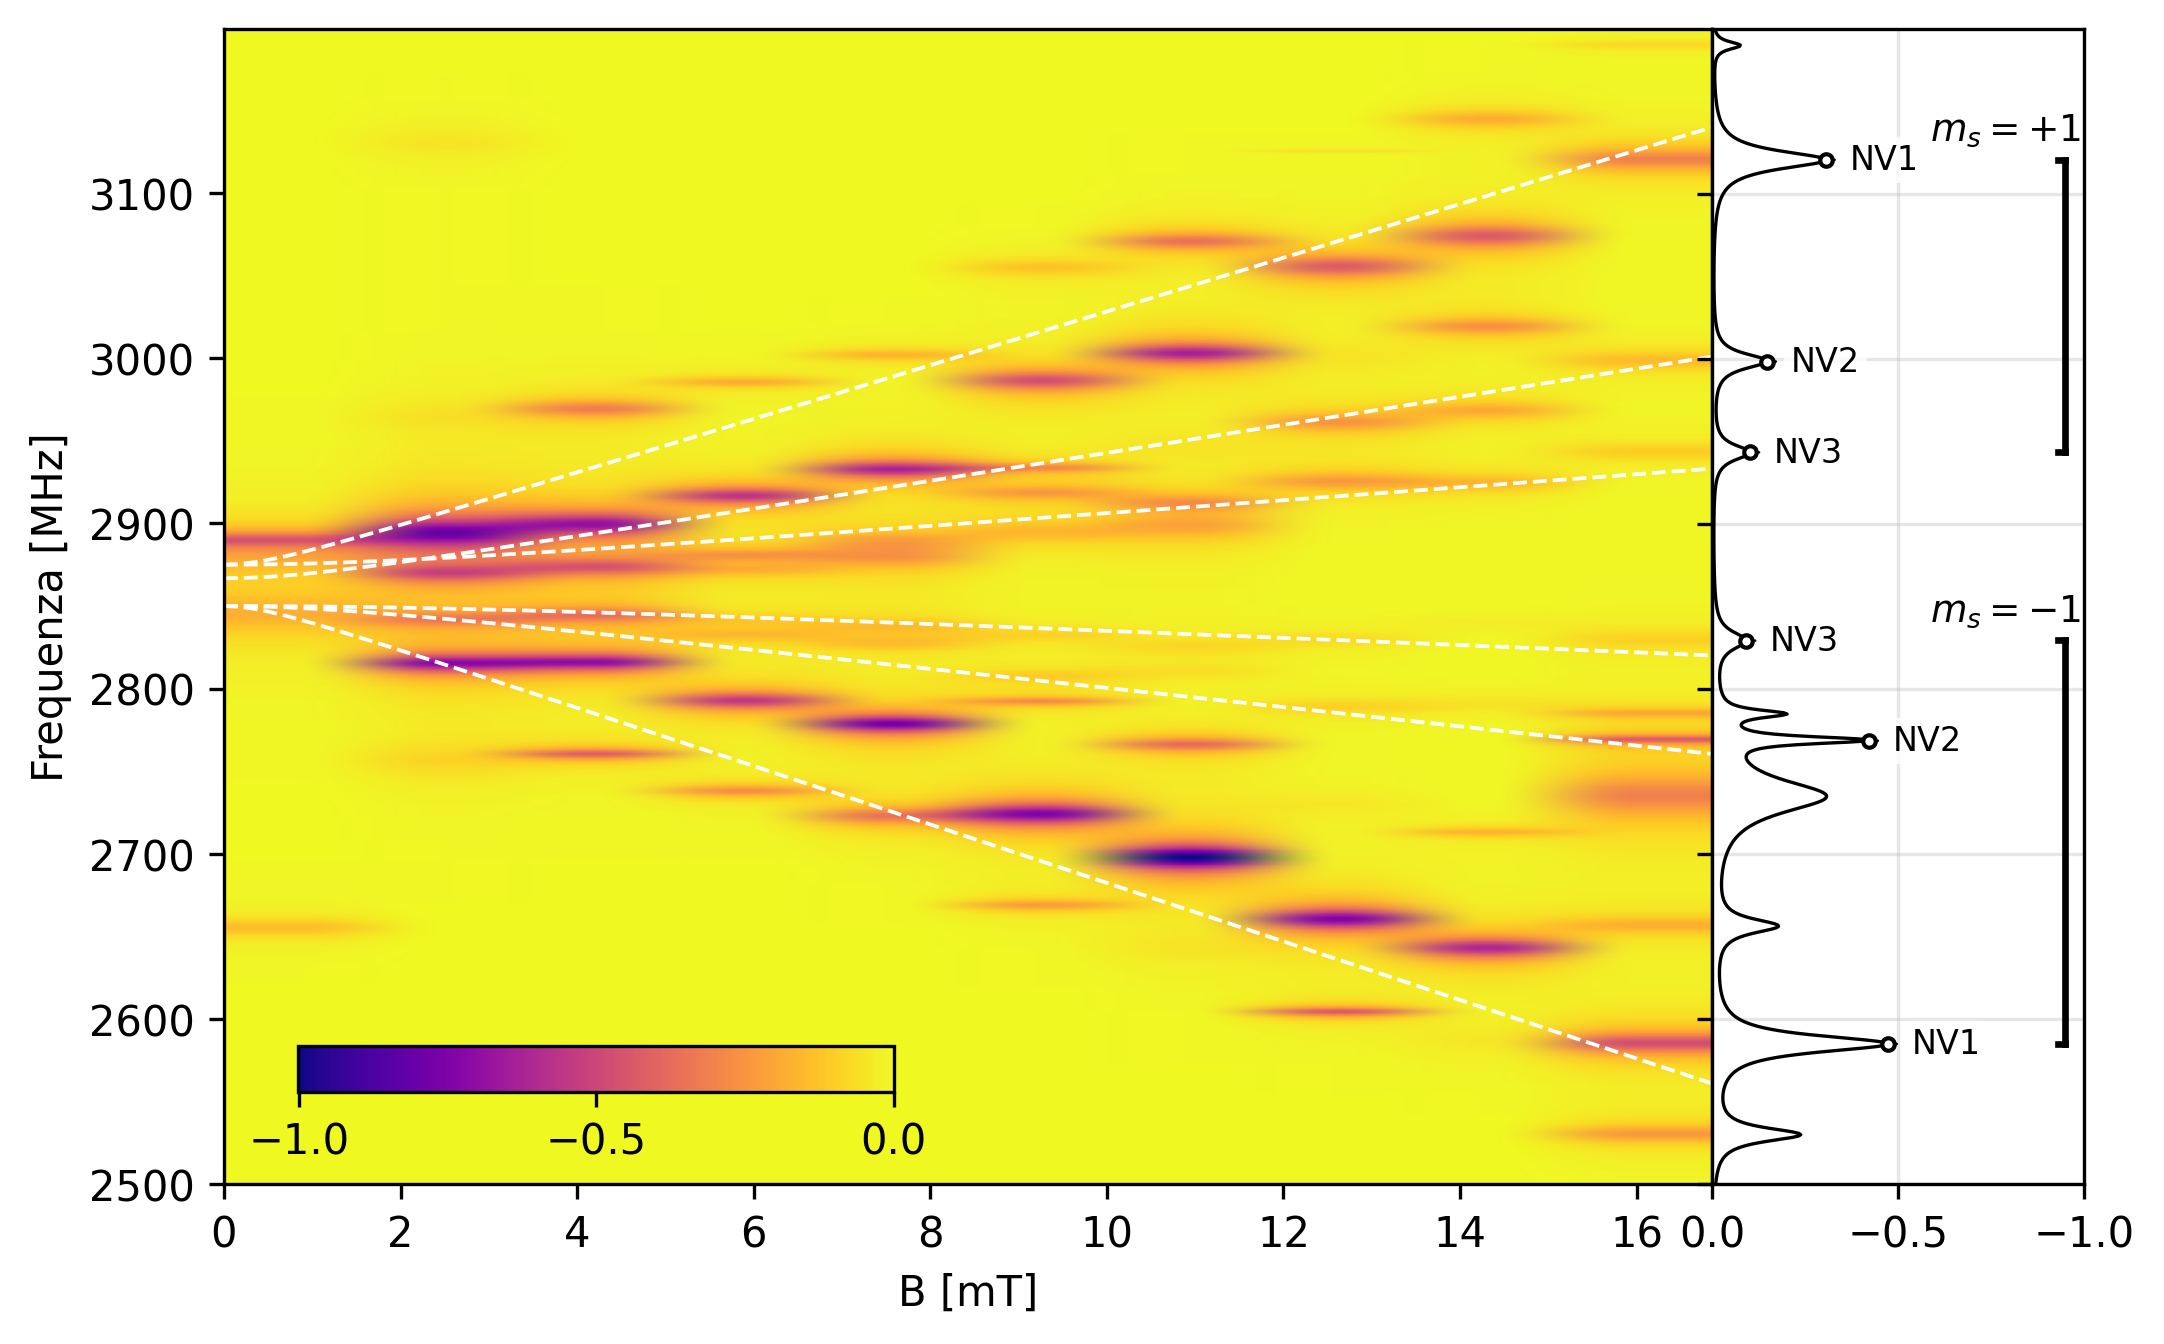

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as mtransforms

# Heatmap con spettro a sinistra - DIMENSIONI MODIFICATE
fig = plt.figure(figsize=(8, 5), dpi=300)  # CAMBIATO: da (10,4) a (8,5)

# Crea una griglia: 1 riga, 2 colonne con larghezze diverse - SPACING RIDOTTO
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1], wspace=0.0)  # CAMBIATO: da wspace=0.05 a 0.0
# Subplot per la heatmap (sinistra)
ax_heatmap = fig.add_subplot(gs[0, 0])
# Subplot per lo spettro (destra)
ax_spettro = fig.add_subplot(gs[0, 1])

# 1. SPETTRO A DESTRA (verticale)
y_axis = np.array(freq_data[-1])  # frequenze
spettro_data = np.array(spectra_data[-1])  # usa il primo spettro (o quello che vuoi)
#mask = (2750 < y_axis) & (y_axis < 2850) HACK: non è il sistema giusto
#spettro_data[mask] = spettro_data[mask]*3
ax_spettro.plot(spettro_data, y_axis, 'k-', linewidth=0.8)
# Estendo un po' il limite superiore per includere i testi m_s
y0, y1 = y_axis[0], y_axis[-1]
y_range = y1 - y0
ax_spettro.set_ylim(y0, y1 + 0.001 * y_range)
ax_spettro.set_xlim(-1, 0)
ax_spettro.invert_xaxis()  # per avere l'origine a destra
ax_spettro.grid(True, alpha=0.3)
ax_spettro.set_yticklabels([])

# 1.b Annotazioni dei "deep" e raggruppamenti m_s
# Valori di frequenza (asse verticale) dove mettere le etichette
DeepMap = {
    'NV1': [3120.6, 2585.01],
    'NV2': [2998.745, 2768.964],
    'NV3': [2943.366, 2829.475],
}

# Offset orizzontale per le etichette rispetto al punto del deep
xlim = ax_spettro.get_xlim()
xrange_abs = abs(xlim[1] - xlim[0])
_dx = 0.25 * xrange_abs  # spostamento per non coprire i picchi

for label, ylist in DeepMap.items():
    for y0_ in ylist:
        # trova il punto dello spettro con frequenza più vicina a y0_
        idx = int(np.argmin(np.abs(np.asarray(y_axis) - y0_)))
        x0 = spettro_data[idx]
        y_pt = y_axis[idx]
        # marker sul deep
        ax_spettro.plot([x0], [y_pt], marker='o', markersize=3, color='white', mec='k', zorder=5)
        # etichetta spostata verso destra (con asse invertito uso x0 - _dx)
        ax_spettro.annotate(
            label,
            xy=(x0, y_pt), xycoords='data',
            xytext=(x0 - _dx, y_pt), textcoords='data',
            ha='right', va='center', fontsize=8, color='k', zorder=6,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.2'),
            arrowprops=dict(arrowstyle='-', lw=0.6, color='k')
        )

# Disegno due "graffe" verticali per i gruppi m_s=+1 (in alto) e m_s=-1 (in basso)
# Uso i valori dal DeepMap: primo valore di ciascuna coppia = gruppo alto, secondo = gruppo basso
plus_group = [DeepMap['NV1'][0], DeepMap['NV2'][0], DeepMap['NV3'][0]]
minus_group = [DeepMap['NV1'][1], DeepMap['NV2'][1], DeepMap['NV3'][1]]
yp_min, yp_max = min(plus_group), max(plus_group)
ym_min, ym_max = min(minus_group), max(minus_group)

# Uso un transform blended: x in coordinate dell'asse (frazione), y in dati
trans = mtransforms.blended_transform_factory(ax_spettro.transAxes, ax_spettro.transData)

# Parametri estetici graffe: le porto DENTRO l'asse per non tagliare testo
x_brace = 0.95         # dentro il riquadro assi
brace_tick = 0.02      # lunghezza dei "cap" orizzontali
x_label = min(0.995, x_brace + brace_tick + 0.015)  # posizione testo a destra della graffa, ma dentro

y_text_offset = 0.02 * y_range  # alzo i testi sopra le graffe

# m_s = +1 (alto) - cappucci verso SINISTRA (graffa "]")
ax_spettro.plot([x_brace, x_brace], [yp_min, yp_max], transform=trans, color='k', lw=1.6, clip_on=False)
ax_spettro.plot([x_brace, x_brace - brace_tick], [yp_min, yp_min], transform=trans, color='k', lw=1.6, clip_on=False)
ax_spettro.plot([x_brace, x_brace - brace_tick], [yp_max, yp_max], transform=trans, color='k', lw=1.6, clip_on=False)
ax_spettro.text(x_label-0.4, yp_max + y_text_offset/2, r'$m_s=+1$',
                transform=trans, va='bottom', ha='left', fontsize=9, clip_on=False)

# m_s = -1 (basso) - cappucci verso SINISTRA (graffa "]")
ax_spettro.plot([x_brace, x_brace], [ym_min, ym_max], transform=trans, color='k', lw=1.6, clip_on=False)
ax_spettro.plot([x_brace, x_brace - brace_tick], [ym_min, ym_min], transform=trans, color='k', lw=1.6, clip_on=False)
ax_spettro.plot([x_brace, x_brace - brace_tick], [ym_max, ym_max], transform=trans, color='k', lw=1.6, clip_on=False)
ax_spettro.text(x_label-0.4, ym_max + y_text_offset/2, r'$m_s=-1$',
                transform=trans, va='bottom', ha='left', fontsize=9, clip_on=False)

# 2. HEATMAP A SINISTRA (nuovo schema colori)
x_axis = previsioni_B
im = ax_heatmap.imshow(
    Z_spectro,
    aspect='auto',
    cmap='plasma', # viridis, plasma, inferno, magma, coolwarm, RdYlBu_r, 
    extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]],
    origin='lower'
)

# 3. Curve sovrapposte
x_fit = np.linspace(x_axis[0], x_axis[-1], 100)
for i, popt in enumerate(popt_array):
    y_fit = funzione_fit_minus(x_fit, popt[0]/1000, popt[1]) if i < 3 else funzione_fit_plus(x_fit, popt[0]/1000, popt[1])
    ax_heatmap.plot(x_fit, y_fit, linestyle='--', color='white', linewidth=0.9)

# 4. Labels
ax_heatmap.set_xlabel('B [mT]')
ax_heatmap.set_ylabel('Frequenza [MHz]')

# 5. COLORBAR ORIZZONTALE IN BASSO A SINISTRA
cax = inset_axes(ax_heatmap, 
                 width="40%",   # larghezza della colorbar
                 height="4%",   # altezza della colorbar
                 loc='lower left',
                 bbox_to_anchor=(0.05, 0.08, 1, 1),
                 bbox_transform=ax_heatmap.transAxes,
                 borderpad=0)

cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cax.patch.set_alpha(0.9)

plt.show()